另外一个 LightGCN MovieLens 的 [notebook] (http://localhost:8888/notebooks/PyTorch_RecSys/LightGCN_for_Movie_Rec%20/LightGCN%20for%20Movie%20Recommendation%20by%20Quinn%20Wang.ipynb) 看的实在是太 struggle 了，而且 recall 非常低，肯定是哪里没写对，我一步步 debug ，不如先看一下这个，我突然找到这个也是 Stanford 224W 的，也是 LightGCN， 也是 Movie Lens

- Blog: https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e
- Code: https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing


突然发现这个内容好像似曾相识啊.. 难道我很早以前就看过?

# Imports

In [1]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Load Dataset

In [2]:
# download the dataset
# Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [3]:
# load user and movie nodes
# def load_node_csv(path, index_col):
#     """Loads csv containing node information

#     Args:
#         path (str): path to csv file
#         index_col (str): column name of index column

#     Returns:
#         dict: mapping of csv row to node id
#     """
#     df = pd.read_csv(path, index_col=index_col)
#     mapping = {index: i for i, index in enumerate(df.index.unique())}
#     return mapping

# # 诶这两只是 dictionary? 所以其实跟另一个一样，也是 label encoder 的 manual 写法, 
# user_mapping = load_node_csv(rating_path, index_col='userId') # 这里其实直接传 user_path 其实也行
# movie_mapping = load_node_csv(movie_path, index_col='movieId')


# new way

rating_df = pd.read_csv(rating_path)

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [4]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


_--------------------- 手动过一下上面 👆🏼的这个 method 知道一下在做什么 --------------------------------_


In [5]:
df = pd.read_csv(movie_path, index_col='movieId')

In [170]:
df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [171]:
# Return unique values in the index.
# 返回的是一个pandas index type, 然后这个 enumerate 居然能拿到 row number 和 index value
# 这个 index type print 一下，其实是一个 list of (row number, index_val)
df.index.unique()

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9742)

In [172]:
for i in enumerate(df.index.unique()):
    print(f"i {i}")

i (0, 1)
i (1, 2)
i (2, 3)
i (3, 4)
i (4, 5)
i (5, 6)
i (6, 7)
i (7, 8)
i (8, 9)
i (9, 10)
i (10, 11)
i (11, 12)
i (12, 13)
i (13, 14)
i (14, 15)
i (15, 16)
i (16, 17)
i (17, 18)
i (18, 19)
i (19, 20)
i (20, 21)
i (21, 22)
i (22, 23)
i (23, 24)
i (24, 25)
i (25, 26)
i (26, 27)
i (27, 28)
i (28, 29)
i (29, 30)
i (30, 31)
i (31, 32)
i (32, 34)
i (33, 36)
i (34, 38)
i (35, 39)
i (36, 40)
i (37, 41)
i (38, 42)
i (39, 43)
i (40, 44)
i (41, 45)
i (42, 46)
i (43, 47)
i (44, 48)
i (45, 49)
i (46, 50)
i (47, 52)
i (48, 53)
i (49, 54)
i (50, 55)
i (51, 57)
i (52, 58)
i (53, 60)
i (54, 61)
i (55, 62)
i (56, 63)
i (57, 64)
i (58, 65)
i (59, 66)
i (60, 68)
i (61, 69)
i (62, 70)
i (63, 71)
i (64, 72)
i (65, 73)
i (66, 74)
i (67, 75)
i (68, 76)
i (69, 77)
i (70, 78)
i (71, 79)
i (72, 80)
i (73, 81)
i (74, 82)
i (75, 83)
i (76, 85)
i (77, 86)
i (78, 87)
i (79, 88)
i (80, 89)
i (81, 92)
i (82, 93)
i (83, 94)
i (84, 95)
i (85, 96)
i (86, 97)
i (87, 99)
i (88, 100)
i (89, 101)
i (90, 102)
i (91, 103)
i (

In [ ]:
# 长这样: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8 ...
# 其实就是 user_id => label encoded user_id (start from 0)
# 这里有个问题，我 COO 这样写，因为是 bipartite graph 其实 movie_node 和 user node 是要区分的..??
print(user_mapping)

In [ ]:
print(movie_mapping)

In [175]:
### 这边试一下 label encoder, 而不是上面得比较难看的写法

rating_df = pd.read_csv(rating_path)



# lbl_user = preprocessing.LabelEncoder()
# lbl_movie = preprocessing.LabelEncoder()

# # 这里才是 apply 上面的 labelEncoder 把 label 都变成 0...n 的 range
# # 他说这里有时候可以一次性 apply 这么多，有时候不行
# df.userId = lbl_user.fit_transform(df.userId.values)
# df.movieId = lbl_movie.fit_transform(df.movieId.values)


In [176]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [177]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

In [178]:
encoded_user_ids = lbl_user.fit_transform(rating_df.userId.values)
encoded_movie_ids = lbl_user.fit_transform(rating_df.movieId.values)

In [179]:
encoded_user_ids

array([  0,   0,   0, ..., 609, 609, 609])

In [180]:
encoded_movie_ids

array([   0,    2,    5, ..., 9444, 9445, 9485])

In [181]:
# 诶，不对好像不是这么用，我得直接把 rating_df 来 transform

In [182]:
rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [183]:
rating_df.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931


In [184]:
encoded_rating_df = rating_df

In [8]:
print(len(user_mapping.keys()))

610


_--------------------- Manual Explore DONE --------------------------------_

In [5]:
# # load edges between users and movies
# def load_edge_csv(path, 
#                   src_index_col, 
#                   src_mapping, 
#                   dst_index_col, 
#                   dst_mapping, 
#                   link_index_col, 
#                   rating_threshold=4):
#     """Loads csv containing edges between users and items

#     Args:
#         path (str): path to csv file
#         src_index_col (str): column name of users
#         src_mapping (dict): mapping between row number and user id
#         dst_index_col (str): column name of items
#         dst_mapping (dict): mapping between row number and item id
#         link_index_col (str): column name of user item interaction
#         rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

#     Returns:
#         torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
#     """
#     df = pd.read_csv(path)
#     edge_index = None
#     src = [src_mapping[index] for index in df[src_index_col]]
#     dst = [dst_mapping[index] for index in df[dst_index_col]]

#     # 这个是我对 item_id 进行 offset
# #     num_users = len(user_mapping.keys())        
# #     dst = [(dst_mapping[index] + num_users) for index in df[dst_index_col]]    

#     edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


#     # 这里就是把 上面的 src list (user), dst list (item), edge_attr(boolean), 转成 PyG Edge_index 需要的COO 格式
#     edge_index = [[], []]
#     for i in range(edge_attr.shape[0]):
#         if edge_attr[i]:
#             edge_index[0].append(src[i])
#             edge_index[1].append(dst[i])

#     return torch.tensor(edge_index)


# ------ new -----
# load edges between users and movies
def load_edge_csv(df, 
                  src_index_col, 
#                   src_mapping, 
                  dst_index_col, 
#                   dst_mapping, 
                  link_index_col, 
                  rating_threshold=3):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    
    edge_index = None
    src = [user_id for user_id in  df['userId']]
    
    num_users = len(df['userId'].unique())
    
    # dst 全部 offset by num_users ，因为是 bipartite graph
#     dst = [(movie_id + num_users) for movie_id in df['movieId']]
    # 改回来
    dst = [(movie_id) for movie_id in df['movieId']]

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    # 这里就是把 上面的 src list (user), dst list (item), edge_attr(boolean), 转成 PyG Edge_index 需要的COO 格式
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            
#     # 弄一下 bidirectional            
#     # deep copy so we have the original version of edge_index[0] to extend to edge_index[1]
#     old_src_edge_index = copy.deepcopy(edge_index[0])
#     edge_index[0].extend(edge_index[1])
#     edge_index[1].extend(old_src_edge_index)
    
#     # 也是因为 bidirectional 上面的处理 (不过好像目前这个写法，后面需需要 edge_attr)
#     edge_attr = torch.cat([edge_attr, edge_attr], dim=0)

    return edge_index




# 这里 print 出来之后，直接就是 COO 格式了!! 即 2 x num_edge_pair. 就是 pyG tutorial 的第一个tutorial 里面的


In [6]:

edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
#     src_mapping=user_mapping,
    dst_index_col='movieId',
#     dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=1,
)

In [7]:
# 弄一下 bidirectional, 但是只给 model 用，不给 eval 用，不然 sample 会有点问题   
# deep copy so we have the original version of edge_index[0] to extend to edge_index[1]
# 估计不能在这里这么弄，不然train, val test split 会有问题....

# bidirectiona_edge_index = copy.deepcopy(edge_index)

# old_src_edge_index = copy.deepcopy(bidirectiona_edge_index[0])
# bidirectiona_edge_index[0].extend(bidirectiona_edge_index[1])
# bidirectiona_edge_index[1].extend(old_src_edge_index)

In [8]:
# 都转成 tensor
edge_index = torch.tensor(edge_index)
# bidirectiona_edge_index = torch.tensor(bidirectiona_edge_index)

In [9]:
# 牛逼，这里 print 出来之后，直接就是 COO 格式了!!
# Q: 但是这里感觉有个问题... 这里是 bipartite graph， 我如果直接 COO 这样写， user_id = 0 盒 item_id = 0 会被当成同一个 node.?
# ?? 有没有可能哪里暗示了是 bipartite graph

# 还真是不太对， 怎么会出现 这么大的数
# 这下就对了，我上面弄的没有用 encoded 的 rating_df 穿进去，而是重新读了，那么不是 label encoded 确实是会有问题

print(edge_index)

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])


_--------------------- 手动过一下上面 👆🏼的这个 method 知道一下在做什么 --------------------------------_


In [10]:
edge_index = None

In [11]:
# rating_df = pd.read_csv(rating_path)

rating_df.head()

NameError: name 'rating_df' is not defined

In [187]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [188]:
type(rating_df['userId'])

pandas.core.series.Series

In [189]:
# 拿到 rating_df 里面的 list of label encoded (start from 0) user_id and movie_id 然后其实就是 src -> dst
# 这样的 edge pair 就是可以 transpose 一下当成 edge_index 用了??
# 回到上面 COO 对于 bipartitate graph 的问题，这样写会不会不小心把 user 和 movie nodes 混淆？？
# 因为这里只是 bipartitate graph 的 interaction matrix 的 COO
# 但是 bipartiate graph interaction matrix 转 Adj Matrix 得垫 0 呀!!! 参考 LightGCN paper formula 6
# 所以我这里， movie node 和 user node 应该要拆开的.. 而且这里还有 bidirectional 的问题
# 而且这里还有 bidirectional 的问题，他都没有解决

# 还有个问题，这里 index 不是 0 -> 100836 这个范围，也就是按照 edge pair, 那我传到 user_mapping是什么个意思？？
# 哦... 没有，这里 index 是一个 overloaded 的 词，index 不是指的 rating_df['userId'] 这个 pandas Series 的 index
# 而是指的实际上 user_id 的数值，他这里就是一个 simply interate the values in pandas series， 然后兑换到
# label encoded starting from 0 的格式.
src = [user_id for user_id in  rating_df['userId']]
dst = [movie_id for movie_id in rating_df['movieId']]


In [ ]:
print(src)

In [191]:
num_users = len(rating_df['userId'].unique())

In [192]:
print(num_users)

610


In [193]:
num_movies = len(rating_df['movieId'].unique())
print(num_movies)

9724


In [194]:
# dst 全部 offset by num_users ，因为是 bipartite graph
dst = [(movie_id + num_users) for movie_id in dst]

In [ ]:
print(dst)

In [196]:
len(src)

100836

In [199]:
print(rating_df['rating'].values)

[4. 4. 4. ... 5. 5. 3.]


In [200]:
# 这里 .view(-1, 1) 就是把 array 包一下，变成 array_length x1 matrix
edge_attr = torch.from_numpy(rating_df['rating'].values).view(-1, 1).to(torch.long) >= 4

In [201]:
print(edge_attr.size())
print(edge_attr)

torch.Size([100836, 1])
tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [False]])


In [67]:
print(edge_attr.shape[0])
        

100836


In [202]:
edge_index = [[], []]
for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
        # 这里还是没有解决 1. interaction matrix 和 adj matrix 的转换， 2. bidirectional 问题？你这里只能 user_id flow to item?
        # 我觉得上面得 offet 一下 index..， 一个就是 bidirectional 弄一下
        # 然后就是 offset 一下 dst(movie_id)
        edge_index[0].append(src[i])
        edge_index[1].append(dst[i])





In [203]:
print(len(edge_index))
print(len(edge_index[0]))
print(len(edge_index[1]))

2
48580
48580


In [204]:
# bidirectional 处理一下   
import copy

# deep copy so we have the original version of edge_index[0] to extend to edge_index[1]
old_src_edge_index = copy.deepcopy(edge_index[0])

edge_index[0].extend(edge_index[1])
edge_index[1].extend(old_src_edge_index)

print(len(edge_index))
print(len(edge_index[0]))
print(len(edge_index[1]))

2
97160
97160


In [205]:
edge_attr = torch.cat([edge_attr, edge_attr], dim=0)

In [206]:
print(edge_attr.size())

torch.Size([201672, 1])


In [207]:
print(torch.tensor(edge_index))

tensor([[    0,     0,     0,  ..., 10053, 10054, 10055],
        [  610,   612,   615,  ...,   609,   609,   609]])


In [9]:
edge_index.size()

torch.Size([2, 48580])

In [12]:
reversed_stacked_edge_index = torch.stack((edge_index[1], edge_index[0]))

In [13]:
print(reversed_stacked_edge_index) 

tensor([[  610,   612,   615,  ..., 10053, 10054, 10055],
        [    0,     0,     0,  ...,   609,   609,   609]])


In [14]:
bidirectional_edge_index = torch.cat((edge_index, reversed_stacked_edge_index), dim=1)

In [15]:
bidirectional_edge_index.size()

torch.Size([2, 97160])

In [12]:
# 这里过一下 gcn norm?
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])


In [13]:
edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=False)

print(edge_index_norm)

(tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]]), tensor([0.0047, 0.0096, 0.0068,  ..., 0.0592, 0.0459, 0.1325]))


In [16]:
print(torch.all(edge_index.eq(edge_index_norm[0])))

tensor(True)


In [33]:
from torch_geometric.utils import degree
def compute_gcn_norm(edge_index, emb):
    emb = emb.weight
    from_, to_ = edge_index
    deg = degree(to_, emb.size(0), dtype=emb.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
    
    return norm

In [35]:
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

emb = nn.Embedding(num_embeddings= (num_users + num_movies), 
                                      embedding_dim=64)


edge_index_norm2 = compute_gcn_norm(edge_index, emb)
print(edge_index_norm2)

tensor([0.0047, 0.0096, 0.0068,  ..., 0.0592, 0.0459, 0.1325])


In [36]:
print(torch.all(edge_index_norm2.eq(edge_index_norm[1])))

tensor(True)


_--------------------- Manual Explore DONE --------------------------------_

In [10]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [11]:
def convert_bipartate_edge_index_to_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [12]:
print(edge_index)
print(edge_index.size())
# bipartate_edge_index = convert_bipartate_edge_index_to_edge_index(edge_index)
# print(bipartate_edge_index.size())


tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])


In [13]:
# 这里其实是算的  4 分以上的 interaction
num_interactions = edge_index.shape[1]
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")


num_users 610, num_movies 9724, num_interactions 99466


In [14]:
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

# 诶，原来 validation 是从test set 里面再 split 出来，我一直以为是从给training set
val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [15]:
# 这里就是拿到 edge pair index 其实还是 tensor, 
# 所以这里其实就是 把 edge_index 拆成 training set, validation set, test set... 
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [16]:
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(edge_index[0]).size())
print(torch.unique(edge_index[1]).size())
print(train_edge_index.min())
print(train_edge_index.max())
print(edge_index.max())

train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([9628])
tensor(0)
tensor(9723)
tensor(9723)


In [17]:
# 这里得把上面的转成 bipartite
train_edge_index = convert_bipartate_edge_index_to_edge_index(train_edge_index)
val_edge_index = convert_bipartate_edge_index_to_edge_index(val_edge_index)
test_edge_index = convert_bipartate_edge_index_to_edge_index(test_edge_index)

In [18]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])


In [19]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
# 这里为啥？？"In PyG >= 1.6.0, we officially introduce better support for sparse-matrix multiplication GNNs, resulting in a lower memory footprint and a faster execution time"


# 这里崩了?? 这是为啥？？
# 难道是因为这里其实才是对 bipartate graph 的处理？？ 你看 sparse size 是 num_users + num_movies
# 我如果不用呢？

# 这里为啥过不来???
# 是不是不能用 num_users + num_movies 了，因为我已经处理了 bipartite?? 那应该用啥？
# 难道是 row, col 的 index 超出范围了? (num_users + num_movies) = 10334
# Solved: load_edge_csv 有个小 bug， 没有用 label encoded 的 id, 
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], 
                                       col=train_edge_index[1], 
                                       sparse_sizes=((num_users + num_movies), num_users + num_movies))

val_sparse_edge_index = SparseTensor(row=val_edge_index[0], 
                                     col=val_edge_index[1], 
                                     sparse_sizes=(num_users + num_movies, num_users + num_movies))

test_sparse_edge_index = SparseTensor(row=test_edge_index[0], 
                                      col=test_edge_index[1], 
                                      sparse_sizes=(num_users + num_movies, num_users + num_movies))




In [20]:
print(train_sparse_edge_index.to_torch_sparse_coo_tensor())

tensor(indices=tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
                       [  610,   615,   653,  ...,   183,   183,   330]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(10334, 10334), nnz=159144, layout=torch.sparse_coo)


In [21]:
print(train_sparse_edge_index)

SparseTensor(row=tensor([    0,     0,     0,  ..., 10331, 10332, 10333]),
             col=tensor([610, 615, 653,  ..., 183, 183, 330]),
             size=(10334, 10334), nnz=159144, density=0.15%)


_-------------------- random explore start --------------------_

In [38]:
R = torch.zeros((num_users, num_movies))

In [39]:
print(R)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [41]:
print(train_edge_index)

tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9024,  792,  ...,  260, 1487, 3872]])


In [42]:
for i in range(len(train_edge_index[0])):
    row_idx = train_edge_index[0][i]
    col_idx = train_edge_index[1][i]
    # print(f"{row_idx}, {col_idx}")
    R[row_idx][col_idx] = 1

In [43]:
# print 一下，看一下 density 咋样
print(R)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [44]:
print(R.size())

torch.Size([610, 9742])


In [45]:
R_transpose = torch.transpose(R, 0, 1)

In [46]:
print(R_transpose.size())

torch.Size([9742, 610])


In [47]:
adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))

In [49]:
print(adj_mat)
print(adj_mat.size())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([10352, 10352])


In [53]:
adj_mat[: num_users, num_users :] = R.clone()
adj_mat[num_users :, : num_users] = R_transpose.clone()

In [54]:
print(adj_mat)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [55]:
adj_mat_coo = adj_mat.to_sparse_coo()

In [56]:
# 这个跟我最后弄的不是一样的?? 有可能不太一样？
print(adj_mat_coo)

tensor(indices=tensor([[    0,     0,     0,  ..., 10349, 10350, 10351],
                       [  610,   615,   653,  ...,   183,   183,   330]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(10352, 10352), nnz=159144, layout=torch.sparse_coo)


_-------------------------- random explore DONE --------------------------_

In [22]:
# function which random samples a mini-batch of positive and negative samples
# 因为我 edge_index 改成 bidirection 了，我这里其实是要改一下的，因为不再是 src 全是 user, dst 全是 target 了
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    # structured_negative_sampling(...) 这个是一个 pyG library
    # Samples a negative edge :obj:`(i,k)` for every positive edge
    # :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns it as a
    # tuple of the form :obj:`(i,j,k)`.
    # 看上面的 print, 其实还是 coo 类似的格式
    edges = structured_negative_sampling(edge_index)
    
    # 变成 3 x num_edge_pair  的格式， 然后 row0, row1 是 positive, row0, row2 是 negative?
    # Q: 他这里怎么知道 negative 是从 movie list 里面拿? 我估计 structured_negative_sampling 知道从 
    # dest list 里面选，而不是从 src list 里面选
    edges = torch.stack(edges, dim=0)
    
    # Return a k sized list of population elements chosen with replacement.
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]
    
    # 上面 batch print 出来知道长啥样，这个就挺 straightforward 
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



__TODO__: 上面这个有点没看懂，得查一下
- https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix
- [拉普拉斯矩阵(Laplacian Matrix) 及半正定性证明](https://www.cnblogs.com/shiyublog/p/9785342.html)
- 我大概知道了，按陈学长跟我讲的去复习一下，然后先把 RMSE 的方法弄一下，然后回头再看下面这几个资料
    - [SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf%EF%BC%89)
    - [LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/pdf/2002.02126.pdf) 尤其 formula 7
    - https://en.m.wikipedia.org/wiki/Laplacian_matrix
    - PyG GCN Norm Doc [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.GCNNorm), [source code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/transforms/gcn_norm.html#GCNNorm)
    - PyG 的 LG_CONV (单层的) Light GCN [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/lg_conv.html#LGConv)
    - PyG 的Light GCN 整个 network [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/lightgcn.html)
    - Normalized Adjacency and Laplacian Matrices Cornell Slides [link](https://people.orie.cornell.edu/dpw/orie6334/Fall2016/lecture7.pdf)
    - [SO]Interpretation of Symmetric Normalised Graph Adjacency Matrix [link](https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix)
- 这个有几个问题，一个是 bipartate graph 的 Adj Matrix 他是不是没有设置好，
- 


In [23]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # 这边 embedding 就参考 我的 Basic NCF 的那个 notebook 
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, 
                                      embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, 
                                      embedding_dim=self.embedding_dim) # e_i^0

        # 这啥？哦就是 上面两 embedding 的 initialization 方法， 当然，也可以把 feature 放进来作为初始 embeding
        # "Fills the input Tensor with values drawn from the normal distribution"
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # TODO: 这个是啥骚操作? 这边得仔细看一下!!! (上面我有做笔记了.)
        # 这里 print 出来之后，长度可能跟 edge_index 不一样了，因为有加 selfloop， 到时候可以验证一下
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # 直接 user, item embedding concat 然后套一曾，然后 rename??
        # 这里不是 64+64 的 concat， 跟 NCF 不一样，这里是 n_users + n_items 的 concat
        # 得到 (n_users + n_items) x 64 的 emb matrix 然后给 edge_index 做 direct indexing 来获得 embedding
        # 这里也体现了 edge_index 要从 R_mat 转成 Adj_mat 的重要性
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        # 哦，不是套一层，而是因为 lightGCN 最后从 多跟 emb_k 算出 emb 是直接加， 所以这里建一个 list
        # 你看后面 propagate 多层 LightGCN layer 的时候，一方面 propagate， 一方面每一层我都 append 到 embs 这个list
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        # 这个跟你用几层 LightGCn 有关，一层，你都 
        # 注意这里，咱们是用 emb_k 作为 node  的 feature 了!!!  
        # TODO: 可以思考一下这里要加真正的 node feature 怎么加？直接 concat? 补进去?
        for i in range(self.K):
            # 他着跟这里讲的不太一样呀？“For bipartite graphs with two independent sets of nodes and indices, and each set holding its own information, this split can be marked by passing the information as a tuple, e.g. x=(x_N, x_M)”
            # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html?highlight=bipartate#the-messagepassing-base-class
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        # 这个到时候可以看一下 dim=1 的 stack 长啥样
        # 可以参考这个 https://www.geeksforgeeks.org/python-pytorch-stack-method/
        # 就是比如 [[1,2,3,4], [5,6,7,8]]
        # stack 完变成[ [1,5], [2,6],[3, 7], [4, 8] ]
        # 这里其实最后出来有 4 个 layer， 因为我们走 range(3), 有三个 但是最初塞进去 emb_0 所以有 4 个
        embs = torch.stack(embs, dim=1)
        
        # 然后这边就是把上面 stack 完的求均值
        # Q: ?? lightGCN 是求均值吗? 不是应该是 weighted sum?? 不过 sum or avg 应该都不影响结果
        # A: 看 paper 里面， 公式里的 a 其实是 1/(K+1) 那本质上就是 avg 了
        emb_final = torch.mean(embs, dim=1) # E^K

        # 这个比较 straightforward, 我们上面 embedding 不是用 concat 把 user_emb 和 item_emb 给
        # horizontal 连起来吗， 这里跑完 LightGCN layer 之后，我们就可以在 split 拆开左右两边，拿到各种的 embedding
        # 那其实跟 NCF 还是蛮像的.
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    # 是不是下面这两个我没有看懂？？
    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    # 是不是下面这个我没有看懂？？
    # 这里也解释的不是很清： https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        # adj_t 是 adj transpose
        # matmul 是 dot product
        return matmul(adj_t, x)

# 试一下只用2层
layers = 3    
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [24]:
# 看公式，还真是需要 layer 0 embedding 作为一个 bias term.. 有意思了..
def bpr_loss(users_emb_final, 
             users_emb_0, 
             pos_items_emb_final, 
             pos_items_emb_0, 
             neg_items_emb_final, 
             neg_items_emb_0, 
             lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [25]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges 也就是 COO 格式

    Returns:
        dict: dictionary of positive items for each user
    """
    
    # key: user_id, val: item_id list
    user_pos_items = {}
    # 在 COO 格式 edge index 的第二个 dim 来 iterate， 也就是 edge pair 一个个过
    for i in range(edge_index.shape[1]):
        # 这里就是拿到一个个 user, item edge pair
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    # 所以这里只要是 edge_index 里面有连接，就是 positive sample??
    return user_pos_items

In [26]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [27]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

_---------------- manual explore START --------------_

In [42]:
model.eval()
# get_metrics(model, val_sparse_edge_index, [train_edge_index], 10)
user_embedding = model.users_emb.weight
item_embedding = model.items_emb.weight

In [44]:
rating = torch.matmul(user_embedding, item_embedding.T)
print(rating)
print(rating.size())
# Need to convert this rating to the Adj matrix form??

tensor([[-0.0962, -0.0498, -0.1559,  ...,  0.0343,  0.0543, -0.0790],
        [ 0.0855, -0.0718,  0.0144,  ...,  0.0802, -0.0061, -0.1246],
        [-0.0630,  0.0190, -0.0203,  ..., -0.0425, -0.0070,  0.0848],
        ...,
        [-0.0480, -0.0553, -0.0576,  ..., -0.0008, -0.0464,  0.2125],
        [ 0.0205, -0.0531, -0.0446,  ...,  0.0066,  0.0214, -0.0210],
        [-0.0579,  0.0684, -0.0027,  ..., -0.0035, -0.1727,  0.1747]],
       grad_fn=<MmBackward0>)
torch.Size([610, 9724])


In [46]:
rating_transpose = torch.transpose(rating, 0, 1)
rating_adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
rating_adj_mat[: num_users, num_users :] = rating.clone()
rating_adj_mat[num_users :, : num_users] = rating_transpose.clone()

In [48]:
exclude_edge_indices = [train_edge_index]
for exclude_edge_index in exclude_edge_indices:
    # gets all the positive items for each user from the edge index
    user_pos_items = get_user_positive_items(exclude_edge_index)
    # get coordinates of all edges to exclude
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        # 这个是为啥？为啥还 * len(item)
        exclude_users.extend([user] * len(items))
        exclude_items.extend(items)



    # set ratings of excluded edges to large negative value
    # 这一步崩的?? 想一想我的 bipartite 的处理，怎么去做这个 encoding 的offset 比较好一点...
    # 不然老是 index 出错， 我这里先笨方法，直接先 减 num_users 了.. TODO: 得想想有没有更 clean 的方法
    exclude_items = [item_id - num_users for item_id in exclude_items]

    # 这里就是设成一个非常小的数， 为啥要这个?? 因为下面有个rating
    rating_adj_mat[exclude_users, exclude_items] = -(1 << 10) 

In [51]:
k = 10
# get the top k recommended items for each user
_, top_K_items = torch.topk(rating_adj_mat, k=k)
print(top_K_items)
print(top_K_items.size())

tensor([[ 4386, 10059,  2861,  ...,  8427,  1391,  8623],
        [ 5259,  3821,  7624,  ...,  3448,  7011,  6293],
        [ 1036,  3447,  6090,  ...,  4979,  4599,  9535],
        ...,
        [   64,   450,   397,  ...,    43,   370,   337],
        [   51,   565,   399,  ...,   327,   219,   435],
        [   87,    82,   398,  ...,    73,   488,    35]])
torch.Size([10334, 10])


In [52]:
# get all unique users in evaluated split
users = edge_index[0].unique()

# 得到一个 dict of user -> pos_item list
test_user_pos_items = get_user_positive_items(edge_index)

# convert test user pos items dictionary into a list
test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

# determine the correctness of topk predictions
# r here is the ground truth??
r = []
for user in users:
    ground_truth_items = test_user_pos_items[user.item()]
    label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
    r.append(label)

r = torch.Tensor(np.array(r).astype('float'))

recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

# print(recall, precision, ndcg)

In [53]:
print(f"recall {recall}, precision {precision}, ndcg {ndcg}")

recall 0.0002658979210536927, precision 0.003934426233172417, ndcg 0.004555956460535526


_---------------- manual explore END --------------_

In [28]:
# wrapper function to get evaluation metrics
# 这一段好好看一下?? 我好奇为什么 BPR loss 往下走的，暗示 recall 没有.

# 这边我看上面是直接拿 [train_edge_index] 作为 exclude_edge_index, 因为你是做 evaluation
# 他为什么要 exclude?? 哦，因为我 validation 的时候，我的 relevant item 要只看 validation set 里面的? 
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    # Matrix product of two tensors. 
    # 这么神奇？哦，不过也 make sense  (num_users x 64) dot_product (num_item x 64).T 那么每个 entry 其实就是pred rating
    rating = torch.matmul(user_embedding, item_embedding.T)
    
    # 这里把 rating 从 interaction mat 转成 bipartite adj mat 为了后面好算？
    rating_transpose = torch.transpose(rating, 0, 1)
    rating_adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    rating_adj_mat[: num_users, num_users :] = rating.clone()
    rating_adj_mat[num_users :, : num_users] = rating_transpose.clone()

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        # 这里应该只是转成  user -> positive item list
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            # 这个是为啥？为啥还 * len(item)， 为了平衡吗？非得把 exclude_user 的长度跟 exclude_item 长度一样
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

            
            
        # set ratings of excluded edges to large negative value
        # 这一步崩的?? 想一想我的 bipartite 的处理，怎么去做这个 encoding 的offset 比较好一点...
        # 不然老是 index 出错， 我这里先笨方法，直接先 减 num_users 了.. TODO: 得想想有没有更 clean 的方法
        # 诶，卧槽，这里忘记改了，这里得拿掉，，我用大 matrix 不需要 offset...
        # exclude_items = [item_id - num_users for item_id in exclude_items]
        
        # 这里就是设成一个非常小的数， 为啥要这个?? 因为下面有个rating
        rating_adj_mat[exclude_users, exclude_items] = -(1 << 10) 

    # get the top k recommended items for each user
    # 其实这里，我应该只需要前 num_user 个？
    _, top_K_items = torch.topk(rating_adj_mat, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # 得到一个 dict of user -> pos_item list
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list， 那这不是成了 list of list?
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    # r here is the ground truth?? 也就是 pred_relevant_and_is_actually_relevant item list for each user
    # 这里是 list of list 的格式
    r = []
    for user in users:
        # 拿到每个 user  的 relevant items
        ground_truth_items = test_user_pos_items[user.item()]
        # 这啥？哦, python 的 lambda 写法，其实是对 top_K_items[user]， 也就是 recommended top k
        # 看有多少是 actually relevant ， 这样 我的  recall 的分子 就拿到了
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [29]:
# TODO: 上面这个过一下!

In [30]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    # bipartite graph 的处理
    users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)
    users_items_emb_0 = torch.cat([users_emb_0, items_emb_0], dim=0)
    
    users_emb_final, users_emb_0 = users_items_emb_final[user_indices], users_items_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = users_items_emb_final[pos_item_indices], users_items_emb_0[pos_item_indices]
    
    neg_items_emb_final, neg_items_emb_0 = users_items_emb_final[neg_item_indices], users_items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, 
                    users_emb_0, 
                    pos_items_emb_final, 
                    pos_items_emb_0,
                    neg_items_emb_final, 
                    neg_items_emb_0, 
                    lambda_val).item()

    #... 这里崩了... 也真是无语.... 改个 bipartite 这么难... 
    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [31]:
# define contants
ITERATIONS = 10000
EPOCHS = 10
# ITERATIONS = 500
BATCH_SIZE = 1024
# 我觉得下面写的有点问题，不然我每个 batch 都是全部数据吧?
# BATCH_SIZE = len(train_edge_index[0])

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
# K = 10
# K = 10 是不是太多了?? 这个会导致 layer oversmooth? 不过好像没有用这个 K? 哦，不是，这个是 eval metric的 K 
K = 20
LAMBDA = 1e-6
# LAMBDA = 1/2

In [32]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [33]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [34]:
def to_bidirectional(edge_index): 
    reversed_stacked_edge_index = torch.stack([edge_index[1], edge_index[0]])
    bidirectional_edge_index = torch.cat([edge_index, reversed_stacked_edge_index], dim=1)
    return bidirectional_edge_index

_------------- manual explore START ----------------_

In [37]:
users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

In [38]:
print(users_emb_final)

tensor([[-3.9762e-02,  7.4816e-03, -1.5521e-02,  ...,  1.8767e-02,
         -2.6990e-02, -9.7426e-05],
        [ 1.9574e-03, -1.2951e-02, -2.9162e-02,  ..., -3.4635e-02,
         -5.6651e-02, -4.3597e-02],
        [ 1.8375e-02, -5.6827e-03,  5.5677e-02,  ...,  2.7837e-02,
         -4.2180e-02, -3.0341e-02],
        ...,
        [ 8.4050e-03, -3.2475e-02,  5.2757e-03,  ...,  3.0839e-02,
         -1.3122e-02, -2.6288e-02],
        [-1.8939e-02, -1.5831e-02,  1.3536e-02,  ...,  1.4358e-02,
          5.9169e-03,  1.4009e-02],
        [ 3.4366e-02,  2.5208e-02,  3.4782e-02,  ..., -2.9481e-02,
         -3.8520e-02,  8.6090e-03]], grad_fn=<SplitWithSizesBackward0>)


In [122]:
user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)

In [125]:
print(user_indices)
print(pos_item_indices)
print(neg_item_indices)

tensor([ 317,  199, 2088,  ...,   17, 3836,  519])
tensor([5032, 7429,   81,  ..., 9030,  159, 1914])
tensor([4064, 1862, 6840,  ..., 9931, 6557,  960])


In [126]:
# 这边得改的，不然没法知道 user 或者 item 的... 或者不需要知道??? 直接看大小?
user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    

In [129]:
users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)
users_items_emb_0 = torch.cat([users_emb_0, items_emb_0], dim=0)
    

In [131]:
users_emb_final, users_emb_0 = users_items_emb_final[user_indices], users_items_emb_0[user_indices]

In [132]:
print(users_emb_final)

tensor([[-7.5016e-03, -2.3561e-02, -2.3633e-02,  ..., -6.7526e-02,
          1.3832e-02,  2.2131e-02],
        [-1.7100e-02,  3.7700e-02,  1.0662e-02,  ...,  1.4128e-02,
         -1.5757e-02,  1.5554e-02],
        [-2.4276e-02,  4.8606e-02, -2.2922e-03,  ...,  1.6238e-02,
          6.3768e-02,  7.4316e-03],
        ...,
        [-2.8978e-02, -1.6520e-02,  2.9376e-02,  ...,  2.2985e-02,
         -2.3847e-02, -2.6981e-02],
        [ 3.3428e-02, -2.9201e-02, -5.4495e-02,  ...,  6.2502e-03,
          4.5260e-02, -1.3935e-02],
        [-4.9883e-03, -1.8013e-03,  6.5619e-02,  ..., -9.8832e-05,
         -1.8107e-02, -5.0942e-03]], grad_fn=<IndexBackward0>)


In [133]:
pos_items_emb_final, pos_items_emb_0 = users_items_emb_final[pos_item_indices], users_items_emb_0[pos_item_indices]

# 拿到第一层，和最后一层的 negative item embedding?    
neg_items_emb_final, neg_items_emb_0 = users_items_emb_final[neg_item_indices], users_items_emb_0[neg_item_indices]


In [137]:
train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

In [138]:
print(train_loss)

tensor(-0.6922, grad_fn=<AddBackward0>)


_------------- manual explore END ----------------_

In [35]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation
    # todo: 估计是这里要给他转成 bidirectional 的，这样信息才完整
#     bidirectional_train_edge_index = to_bidirectional(train_edge_index)
    
#     bidirectional_train_sparse_edge_index = SparseTensor(
#                                        row=bidirectional_train_edge_index[0], 
#                                        col=bidirectional_train_edge_index[1], 
#                                        sparse_sizes=((num_users + num_movies), num_users + num_movies))

    
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    # print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")
    
    # 全部转成 to(device) 的格式
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
    
    # concat 一下，不然我的 bipartite 处理之后, item 的 range 已经变了
#     users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)
#     users_items_emb_0 = torch.cat([users_emb_0, items_emb_0], dim=0)
    
    
    # 拿到第一层，和最后一层的 user embedding?
    users_emb_final, users_emb_0 = users_items_emb_final[user_indices], users_emb_0[user_indices]

    # 拿到第一层，和最后一层的 positive item embedding?
    # TODO; 这里要记得 干脆 user 和 item embedding concat 一下，不然总是出街
    pos_items_emb_final, pos_items_emb_0 = users_items_emb_final[pos_item_indices], users_items_emb_0[pos_item_indices]

    # 拿到第一层，和最后一层的 negative item embedding?    
    neg_items_emb_final, neg_items_emb_0 = users_items_emb_final[neg_item_indices], users_items_emb_0[neg_item_indices]

    # loss computation
    # TODO；  这边看一下能不能 incorporate RMSE loss 这样也许 recall 就会提高不少
    # 当然，要思考一下，他这边怎么去算 RMSE loss? 不过应该是有 edge index 本质上是edge pair 应该是可以算吧?
    # Question: BPR loss 需要最后一层和第一层吗？？
    train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 这里就是过 validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
#         bidirectional_val_edge_index = to_bidirectional(val_edge_index)
    
#         bidirectional_val_sparse_edge_index = SparseTensor(
#                                        row=bidirectional_val_edge_index[0], 
#                                        col=bidirectional_val_edge_index[1], 
#                                        sparse_sizes=((num_users + num_movies), num_users + num_movies))

        
        # 为啥这里需要 val_sparse_edge_index
        val_loss, recall, precision, ndcg = evaluation(model, 
                                                       val_edge_index, 
                                                       val_sparse_edge_index, 
                                                       [train_edge_index], 
                                                       K, 
                                                       LAMBDA)
        
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|                                                                                        | 1/10000 [00:06<18:01:59,  6.49s/it]

[Iteration 0/10000] train_loss: -0.69214, val_loss: -0.663, val_recall@20: 0.03107, val_precision@20: 0.00499, val_ndcg@20: 0.01472


  2%|█▋                                                                                     | 201/10000 [01:04<5:04:22,  1.86s/it]

[Iteration 200/10000] train_loss: -6.54626, val_loss: -5.06954, val_recall@20: 0.08194, val_precision@20: 0.01639, val_ndcg@20: 0.04344


  4%|███▍                                                                                   | 401/10000 [01:58<4:46:14,  1.79s/it]

[Iteration 400/10000] train_loss: -28.17191, val_loss: -20.90889, val_recall@20: 0.10483, val_precision@20: 0.02083, val_ndcg@20: 0.05223


  6%|█████▏                                                                                 | 601/10000 [02:48<4:34:38,  1.75s/it]

[Iteration 600/10000] train_loss: -56.54773, val_loss: -43.72846, val_recall@20: 0.12794, val_precision@20: 0.02361, val_ndcg@20: 0.06488


  8%|██████▉                                                                                | 801/10000 [03:37<4:27:28,  1.74s/it]

[Iteration 800/10000] train_loss: -90.70711, val_loss: -72.68564, val_recall@20: 0.14167, val_precision@20: 0.02588, val_ndcg@20: 0.07019


 10%|████████▌                                                                             | 1001/10000 [04:27<4:28:43,  1.79s/it]

[Iteration 1000/10000] train_loss: -135.98444, val_loss: -105.09554, val_recall@20: 0.15363, val_precision@20: 0.02737, val_ndcg@20: 0.07614


 12%|██████████▎                                                                           | 1201/10000 [05:17<4:13:10,  1.73s/it]

[Iteration 1200/10000] train_loss: -188.19556, val_loss: -141.12962, val_recall@20: 0.15427, val_precision@20: 0.02795, val_ndcg@20: 0.07631


 14%|████████████                                                                          | 1401/10000 [06:08<4:11:24,  1.75s/it]

[Iteration 1400/10000] train_loss: -238.17596, val_loss: -179.03951, val_recall@20: 0.14948, val_precision@20: 0.02821, val_ndcg@20: 0.07613


 16%|█████████████▊                                                                        | 1601/10000 [06:57<4:05:20,  1.75s/it]

[Iteration 1600/10000] train_loss: -284.24704, val_loss: -216.62227, val_recall@20: 0.16227, val_precision@20: 0.02977, val_ndcg@20: 0.08093


 18%|███████████████▍                                                                      | 1801/10000 [07:47<4:01:10,  1.76s/it]

[Iteration 1800/10000] train_loss: -323.19067, val_loss: -257.10925, val_recall@20: 0.17324, val_precision@20: 0.03092, val_ndcg@20: 0.08587


 20%|█████████████████▏                                                                    | 2001/10000 [08:41<4:52:12,  2.19s/it]

[Iteration 2000/10000] train_loss: -384.85382, val_loss: -295.02008, val_recall@20: 0.17071, val_precision@20: 0.03103, val_ndcg@20: 0.08775


 22%|██████████████████▉                                                                   | 2201/10000 [09:47<6:11:38,  2.86s/it]

[Iteration 2200/10000] train_loss: -426.51544, val_loss: -336.19891, val_recall@20: 0.17486, val_precision@20: 0.03127, val_ndcg@20: 0.08967


 24%|████████████████████▋                                                                 | 2401/10000 [10:57<7:36:18,  3.60s/it]

[Iteration 2400/10000] train_loss: -473.41315, val_loss: -377.04083, val_recall@20: 0.17935, val_precision@20: 0.03188, val_ndcg@20: 0.09189


 26%|██████████████████████▎                                                               | 2601/10000 [12:00<4:07:00,  2.00s/it]

[Iteration 2600/10000] train_loss: -559.48853, val_loss: -414.71686, val_recall@20: 0.17964, val_precision@20: 0.03205, val_ndcg@20: 0.0933


 28%|████████████████████████                                                              | 2801/10000 [13:00<4:00:43,  2.01s/it]

[Iteration 2800/10000] train_loss: -584.57446, val_loss: -452.66159, val_recall@20: 0.18207, val_precision@20: 0.03208, val_ndcg@20: 0.09582


 30%|█████████████████████████▊                                                            | 3001/10000 [13:57<3:53:21,  2.00s/it]

[Iteration 3000/10000] train_loss: -640.82574, val_loss: -491.10928, val_recall@20: 0.18438, val_precision@20: 0.03241, val_ndcg@20: 0.09662


 32%|███████████████████████████▌                                                          | 3201/10000 [14:57<4:10:39,  2.21s/it]

[Iteration 3200/10000] train_loss: -671.87213, val_loss: -527.05103, val_recall@20: 0.18565, val_precision@20: 0.03253, val_ndcg@20: 0.09845


 34%|█████████████████████████████▏                                                        | 3401/10000 [16:03<3:41:47,  2.02s/it]

[Iteration 3400/10000] train_loss: -698.91205, val_loss: -562.00812, val_recall@20: 0.18673, val_precision@20: 0.03295, val_ndcg@20: 0.09956


 36%|██████████████████████████████▉                                                       | 3601/10000 [16:58<3:23:46,  1.91s/it]

[Iteration 3600/10000] train_loss: -746.30096, val_loss: -593.12512, val_recall@20: 0.18765, val_precision@20: 0.03319, val_ndcg@20: 0.09974


 38%|████████████████████████████████▋                                                     | 3801/10000 [17:55<3:45:09,  2.18s/it]

[Iteration 3800/10000] train_loss: -823.09766, val_loss: -626.52545, val_recall@20: 0.18862, val_precision@20: 0.0334, val_ndcg@20: 0.09985


 40%|██████████████████████████████████▍                                                   | 4001/10000 [18:49<3:11:42,  1.92s/it]

[Iteration 4000/10000] train_loss: -868.79315, val_loss: -656.64758, val_recall@20: 0.188, val_precision@20: 0.03328, val_ndcg@20: 0.10099


 42%|████████████████████████████████████▏                                                 | 4201/10000 [19:42<3:10:16,  1.97s/it]

[Iteration 4200/10000] train_loss: -914.91675, val_loss: -688.83014, val_recall@20: 0.19011, val_precision@20: 0.03369, val_ndcg@20: 0.10179


 44%|█████████████████████████████████████▊                                                | 4401/10000 [20:39<3:20:11,  2.15s/it]

[Iteration 4400/10000] train_loss: -942.99976, val_loss: -719.02521, val_recall@20: 0.19009, val_precision@20: 0.03366, val_ndcg@20: 0.10224


 46%|███████████████████████████████████████▌                                              | 4601/10000 [21:41<3:34:02,  2.38s/it]

[Iteration 4600/10000] train_loss: -964.03827, val_loss: -747.68329, val_recall@20: 0.19054, val_precision@20: 0.03382, val_ndcg@20: 0.10263


 48%|█████████████████████████████████████████▎                                            | 4801/10000 [22:37<2:56:58,  2.04s/it]

[Iteration 4800/10000] train_loss: -1007.33051, val_loss: -775.62964, val_recall@20: 0.19164, val_precision@20: 0.03406, val_ndcg@20: 0.10292


 50%|███████████████████████████████████████████                                           | 5001/10000 [23:32<2:42:58,  1.96s/it]

[Iteration 5000/10000] train_loss: -1047.79614, val_loss: -801.883, val_recall@20: 0.19099, val_precision@20: 0.03387, val_ndcg@20: 0.1034


 52%|████████████████████████████████████████████▋                                         | 5201/10000 [24:28<2:36:14,  1.95s/it]

[Iteration 5200/10000] train_loss: -1020.98462, val_loss: -824.81134, val_recall@20: 0.19043, val_precision@20: 0.03388, val_ndcg@20: 0.10537


 54%|██████████████████████████████████████████████▍                                       | 5401/10000 [25:28<4:00:16,  3.13s/it]

[Iteration 5400/10000] train_loss: -1111.90576, val_loss: -847.66504, val_recall@20: 0.18653, val_precision@20: 0.03367, val_ndcg@20: 0.10316


 56%|████████████████████████████████████████████████▏                                     | 5601/10000 [26:51<3:44:07,  3.06s/it]

[Iteration 5600/10000] train_loss: -1103.33398, val_loss: -872.64886, val_recall@20: 0.18856, val_precision@20: 0.03381, val_ndcg@20: 0.10591


 58%|█████████████████████████████████████████████████▉                                    | 5801/10000 [28:15<3:33:47,  3.05s/it]

[Iteration 5800/10000] train_loss: -1137.96692, val_loss: -889.77155, val_recall@20: 0.1891, val_precision@20: 0.03389, val_ndcg@20: 0.10543


 60%|███████████████████████████████████████████████████▌                                  | 6001/10000 [29:33<2:54:01,  2.61s/it]

[Iteration 6000/10000] train_loss: -1215.46606, val_loss: -914.35004, val_recall@20: 0.18822, val_precision@20: 0.03387, val_ndcg@20: 0.1043


 62%|█████████████████████████████████████████████████████▎                                | 6201/10000 [30:56<3:27:33,  3.28s/it]

[Iteration 6200/10000] train_loss: -1195.14026, val_loss: -935.04828, val_recall@20: 0.18949, val_precision@20: 0.034, val_ndcg@20: 0.10415


 64%|███████████████████████████████████████████████████████                               | 6401/10000 [32:13<2:38:26,  2.64s/it]

[Iteration 6400/10000] train_loss: -1256.33118, val_loss: -951.73663, val_recall@20: 0.19262, val_precision@20: 0.03409, val_ndcg@20: 0.1068


 66%|████████████████████████████████████████████████████████▊                             | 6601/10000 [33:34<3:06:13,  3.29s/it]

[Iteration 6600/10000] train_loss: -1292.66138, val_loss: -970.30536, val_recall@20: 0.19303, val_precision@20: 0.03426, val_ndcg@20: 0.108


 68%|██████████████████████████████████████████████████████████▍                           | 6801/10000 [34:52<2:35:58,  2.93s/it]

[Iteration 6800/10000] train_loss: -1327.57983, val_loss: -992.46655, val_recall@20: 0.19296, val_precision@20: 0.03437, val_ndcg@20: 0.10814


 70%|████████████████████████████████████████████████████████████▏                         | 7001/10000 [36:08<2:08:49,  2.58s/it]

[Iteration 7000/10000] train_loss: -1345.39539, val_loss: -1008.81506, val_recall@20: 0.19296, val_precision@20: 0.03437, val_ndcg@20: 0.10817


 72%|█████████████████████████████████████████████████████████████▉                        | 7201/10000 [37:26<2:21:22,  3.03s/it]

[Iteration 7200/10000] train_loss: -1336.724, val_loss: -1018.8407, val_recall@20: 0.19337, val_precision@20: 0.03443, val_ndcg@20: 0.10831


 74%|███████████████████████████████████████████████████████████████▋                      | 7401/10000 [38:46<1:58:26,  2.73s/it]

[Iteration 7400/10000] train_loss: -1344.07214, val_loss: -1037.95508, val_recall@20: 0.19288, val_precision@20: 0.03432, val_ndcg@20: 0.10798


 76%|█████████████████████████████████████████████████████████████████▎                    | 7601/10000 [40:01<1:43:56,  2.60s/it]

[Iteration 7600/10000] train_loss: -1348.87036, val_loss: -1051.71838, val_recall@20: 0.19335, val_precision@20: 0.03441, val_ndcg@20: 0.10833


 78%|███████████████████████████████████████████████████████████████████                   | 7801/10000 [41:15<1:33:36,  2.55s/it]

[Iteration 7800/10000] train_loss: -1360.55542, val_loss: -1064.5658, val_recall@20: 0.19346, val_precision@20: 0.03445, val_ndcg@20: 0.1083


 80%|████████████████████████████████████████████████████████████████████▊                 | 8001/10000 [42:29<1:24:53,  2.55s/it]

[Iteration 8000/10000] train_loss: -1410.90662, val_loss: -1080.81738, val_recall@20: 0.1936, val_precision@20: 0.03443, val_ndcg@20: 0.10859


 82%|██████████████████████████████████████████████████████████████████████▌               | 8201/10000 [43:43<1:16:14,  2.54s/it]

[Iteration 8200/10000] train_loss: -1461.88538, val_loss: -1093.43689, val_recall@20: 0.19286, val_precision@20: 0.03437, val_ndcg@20: 0.10847


 84%|████████████████████████████████████████████████████████████████████████▏             | 8401/10000 [44:58<1:11:44,  2.69s/it]

[Iteration 8400/10000] train_loss: -1381.27673, val_loss: -1098.68921, val_recall@20: 0.19342, val_precision@20: 0.03449, val_ndcg@20: 0.10878


 86%|███████████████████████████████████████████████████████████████████████████▋            | 8601/10000 [46:13<59:09,  2.54s/it]

[Iteration 8600/10000] train_loss: -1499.30383, val_loss: -1114.44543, val_recall@20: 0.19346, val_precision@20: 0.0345, val_ndcg@20: 0.10865


 88%|█████████████████████████████████████████████████████████████████████████████▍          | 8801/10000 [47:27<50:01,  2.50s/it]

[Iteration 8800/10000] train_loss: -1429.4248, val_loss: -1126.89355, val_recall@20: 0.19398, val_precision@20: 0.03459, val_ndcg@20: 0.10894


 90%|███████████████████████████████████████████████████████████████████████████████▏        | 9001/10000 [48:41<43:54,  2.64s/it]

[Iteration 9000/10000] train_loss: -1420.45911, val_loss: -1136.86926, val_recall@20: 0.19396, val_precision@20: 0.03459, val_ndcg@20: 0.1092


 92%|████████████████████████████████████████████████████████████████████████████████▉       | 9201/10000 [49:59<36:50,  2.77s/it]

[Iteration 9200/10000] train_loss: -1440.91382, val_loss: -1149.68884, val_recall@20: 0.19361, val_precision@20: 0.03451, val_ndcg@20: 0.1092


 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 9401/10000 [51:16<27:29,  2.75s/it]

[Iteration 9400/10000] train_loss: -1444.49866, val_loss: -1153.21399, val_recall@20: 0.19338, val_precision@20: 0.0345, val_ndcg@20: 0.10912


 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 9601/10000 [52:34<17:55,  2.69s/it]

[Iteration 9600/10000] train_loss: -1512.54553, val_loss: -1169.49194, val_recall@20: 0.19365, val_precision@20: 0.03455, val_ndcg@20: 0.10914


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 9801/10000 [53:52<09:29,  2.86s/it]

[Iteration 9800/10000] train_loss: -1524.90759, val_loss: -1166.51758, val_recall@20: 0.19349, val_precision@20: 0.03455, val_ndcg@20: 0.10914


100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [55:01<00:00,  3.03it/s]


_--------------------- Manual Explore code above 👆🏼 START --------------------------------_

In [ ]:
users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

In [ ]:
print(f"users_emb_final.size() {users_emb_final.size()}")

print(f"items_emb_final.size(): {items_emb_final.size()}")

In [ ]:
# 这里是要 concat 还是要 stack, 我觉得要 concat..。 但是怎么得到的 dimension 不太对? <<==== Here
users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)

In [64]:
# 这下对了
print(f"users_items_emb_final.size(): {users_items_emb_final.size()}")

users_items_emb_final.size(): torch.Size([10334, 64])


In [43]:
user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")
    

user_indices tensor([2254]), pos_item_indices tensor([606]), neg_item_indices tensor([6704])


In [49]:
# 全部转成 to(device) 的格式
user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")


user_indices tensor([2254]), pos_item_indices tensor([606]), neg_item_indices tensor([6704])


In [ ]:

# 拿到第一层，和最后一层的 user embedding?
# 诶，还真是出界了... 
# 因为我 sample mini batch 的时候，在新的 bipartite 格式，是没有考虑 user 还是 item 的
# 这里其实 >610 就是 item 的 index 了，所以这里要处理一下的
# 或者我直接用一个 embedding 不用分成两个..？
# 不过这样 positive_item, negative_item 就会出问题... hmm...
# 这个得想一想怎么弄... 这个是我因为弄 bidirectional 的缘故..
# .. 或者先不弄 birectional?? 不然咋sample 呀??
# 或者这样，我 传给 model 的是 birectional
# 但是给 sampling 用的不是 birectional， 这样就能抱着 positive 和 negative_item sampling 可以用了

users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

_--------------------- Manual Explore DONE --------------------------------_

# Plot

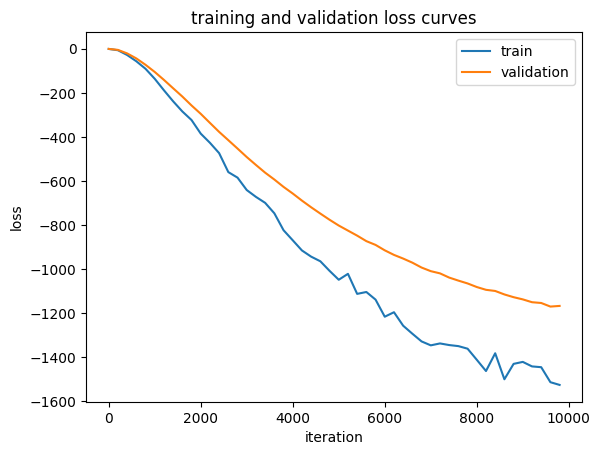

In [36]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

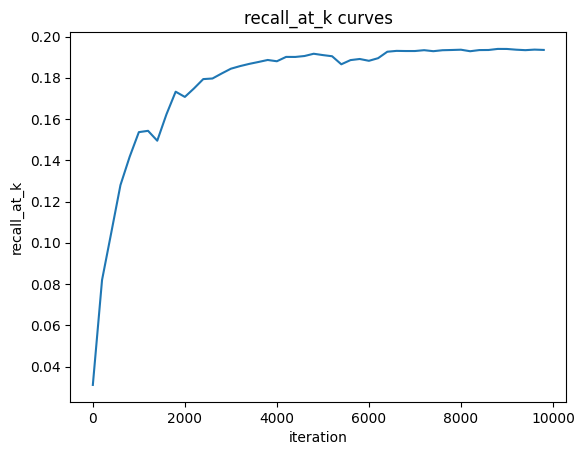

In [37]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [38]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

# bidirectional_test_edge_index = to_bidirectional(test_edge_index)
# bidirectional_test_sparse_edge_index = SparseTensor(
#                                row=bidirectional_test_edge_index[0], 
#                                col=bidirectional_test_edge_index[1], 
#                                sparse_sizes=((num_users + num_movies), num_users + num_movies))



test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               test_sparse_edge_index, 
                                                               # 其实我觉得这里应该只 withhold train_edge_index
                                                               # 因为其实保证 model 没有看见 train data 就行?
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1165.17944, test_recall@20: 0.19547, test_precision@20: 0.03564, test_ndcg@20: 0.11246


发现上面跑出来 效果也一般般
我把原始代码的output 记录一下
- [test_loss: -51.5177, test_recall@10: 0.08269, test_precision@10: 0.05815, test_ndcg@10: 0.09033

卧槽，改了半天 bipartite，改了个寂寞？ (不过我的 iter 用的 500 而不是 10000 好吧，再试一下)
（好像还是不太行，不然我把 bidirectional 拿掉？没有差，好像还是挺差.. 这个真多要歇会儿了... ）

[test_loss: -29.82772, test_recall@10: 0.00317, test_precision@10: 0.00163, test_ndcg@10: 0.00212


TRY: 我试一下只用一层？？(也不想

TRY: 我试一下 threshold 用 >=1
- 不行: [test_loss: -51.26439, test_recall@10: 0.00361, test_precision@10: 0.00127, test_ndcg@10: 0.00182
- 不过我好像有个地方漏改了，所以其实还是 >=4 。。。难怪跟之前一样
- TODO need redo:


Thoughts: 我怀疑我还是 sparse tensor 没有理解对

TRY: 实在不行，把 Bipartate 的处理拿掉？然后用 label encoded 的再跑一下看一下? 然后threshold 用 >=4, 然后 recall@k 的 k 用 20 (然后看一下 perf 会不会至少跟之前例子是持平的，然后再来试一下 bipartite 我把 threshold 该清楚
- [test_loss: -44.70277, test_recall@20: 0.08734, test_precision@20: 0.03558, test_ndcg@20: 0.06751
- 那就跟原始结果差不多
- 发现 threshold at 4 的时候, training density 好低: 
            SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   0,    5,   43,  ..., 9443, 9444, 9445]),
             size=(10334, 10334), nnz=79572, density=0.07%)
             
            - 不对，我这已经是用 >=1 和 k = 20 来算的了


_TOTRY_: 用 Bipartite， 而且 threahold 用 >=1
    - 不行， 在前 1500 iter 左右还很低级别就没戏
    
    
_TOTRY_: 改成用原始的 mapping，但是感觉大概率还是不行... 太失望了... 


还发现一个问题，他这每次 train 都是全部一起弄一个 epoch？但是 loss 用的是 batch 的 err? 不太对呀，不是应该

_TOTRY_: 我直接试一下每次 loss 都用整个 batch 的 loss? 而不是 sample batch 的 loss?

_TOTRY_" 我如果不用 sparse matrix?

_Update_: 卧槽，改了 formula 6 的正确写法之后，重要弄出来了 :  ✅

    - [test_loss: -934.20184, test_recall@20: 0.18721, test_precision@20: 0.0367, test_ndcg@20: 0.10241
    - 比原来还是高了不少的 但是真的跑的好久，1h11m... 明天整理一下，然后用 RMSE 试一下
    
_TOTRY_: 发现我应该先 split train/val/test 再转 adj mat 不然有可能 data leak 因为是 symmetric 的 ✅
    - [test_loss: -1165.17944, test_recall@20: 0.19547, test_precision@20: 0.03564, test_ndcg@20: 0.11246
    - 比上面的效果好一点，也 make sense. 因为信息更完整

_ToTRY_: 试一下我直接用 train 好的 model 而不是 edge index 再 propapage 一遍?

# Make New Recommendatios for a Given User

In [ ]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [ ]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    
    # 这里 @ 是 dot product
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [ ]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)